In [95]:
import arviz as az
import json
import matplotlib.pyplot as plt
import math


In [60]:
# load output from fitted model
az_fit = az.from_json("model_output/model_3_voter_bias_vector_no_preds_1000_samples_4_chains_1998-2022.json")

In [62]:
# generate sets of vp indicies for each performer (to show bias from each voter)
with open('generated_objects/vptoi.json') as f:
    vptoi = f.read()
vptoi = json.loads(vptoi)
with open('generated_objects/itovp.json') as f:
    itovp = f.read()
itovp = json.loads(itovp)

votersforp = {}
for pair,idx in vptoi.items():
    v = pair[:2]; p = pair[-2:]
    voters = votersforp.get(p)
    if voters:
        voters.append(idx)
    else:
        votersforp[p] = [idx]

with open('generated_objects/voterforp.json', 'w') as f:
    json.dump(votersforp,f)



In [110]:
# sort alpha parameters based on mean, and print 3 highest and 3 lowest means
alpha_mean = az_fit.posterior.alpha.to_numpy().mean(axis=(0,1))
big_bias = list(map(lambda x:itovp[f'{x}'][-2:],alpha_mean.argsort()[:3])) + list(map(lambda x:itovp[f'{x}'][-2:],alpha_mean.argsort()[-3:]))
# print(list(map(lambda x:itovp[f'{x}'][-2:],alpha_mean.argsort()[:3])))
# print('...')
# print(list(map(lambda x:itovp[f'{x}'][-2:],alpha_mean.argsort()[-3:])))

In [65]:
az_relabelled = az_fit.copy()
label_arr = [None] * len(vptoi)
for pair,idx in vptoi.items():
    label_arr[idx] = pair
az_relabelled.posterior['alpha_dim_0'] = label_arr
az_relabelled.posterior['beta_dim_0'] = ['Contains_English','Contains_Own_Language','Male','Female','Comps_Without_Win']
az_relabelled.posterior['phi_dim_0'] = ['Shared_Border','V2P_Migration_Intensity']


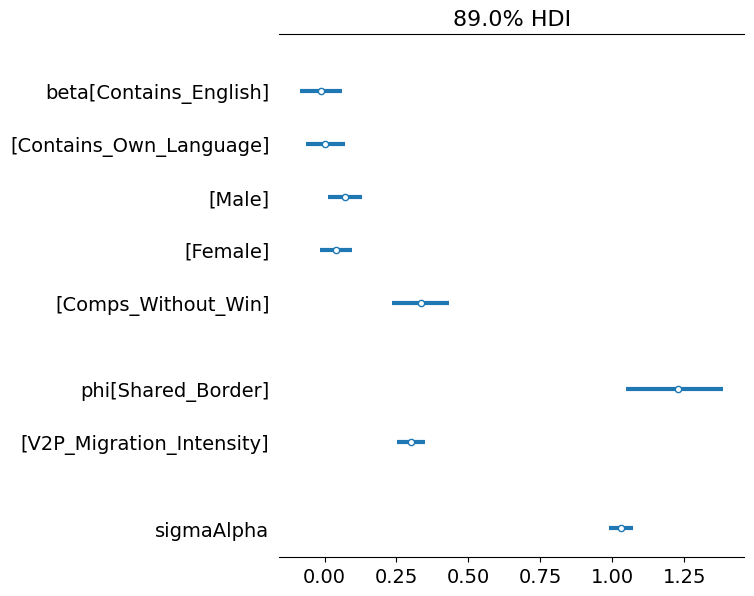

In [66]:
axes = az.plot_forest(az_relabelled,
                        kind='forestplot',
                        combined=True,
                        quartiles=False,
                        hdi_prob=0.89,
                        var_names=['beta','phi','sigmaAlpha']
                        )

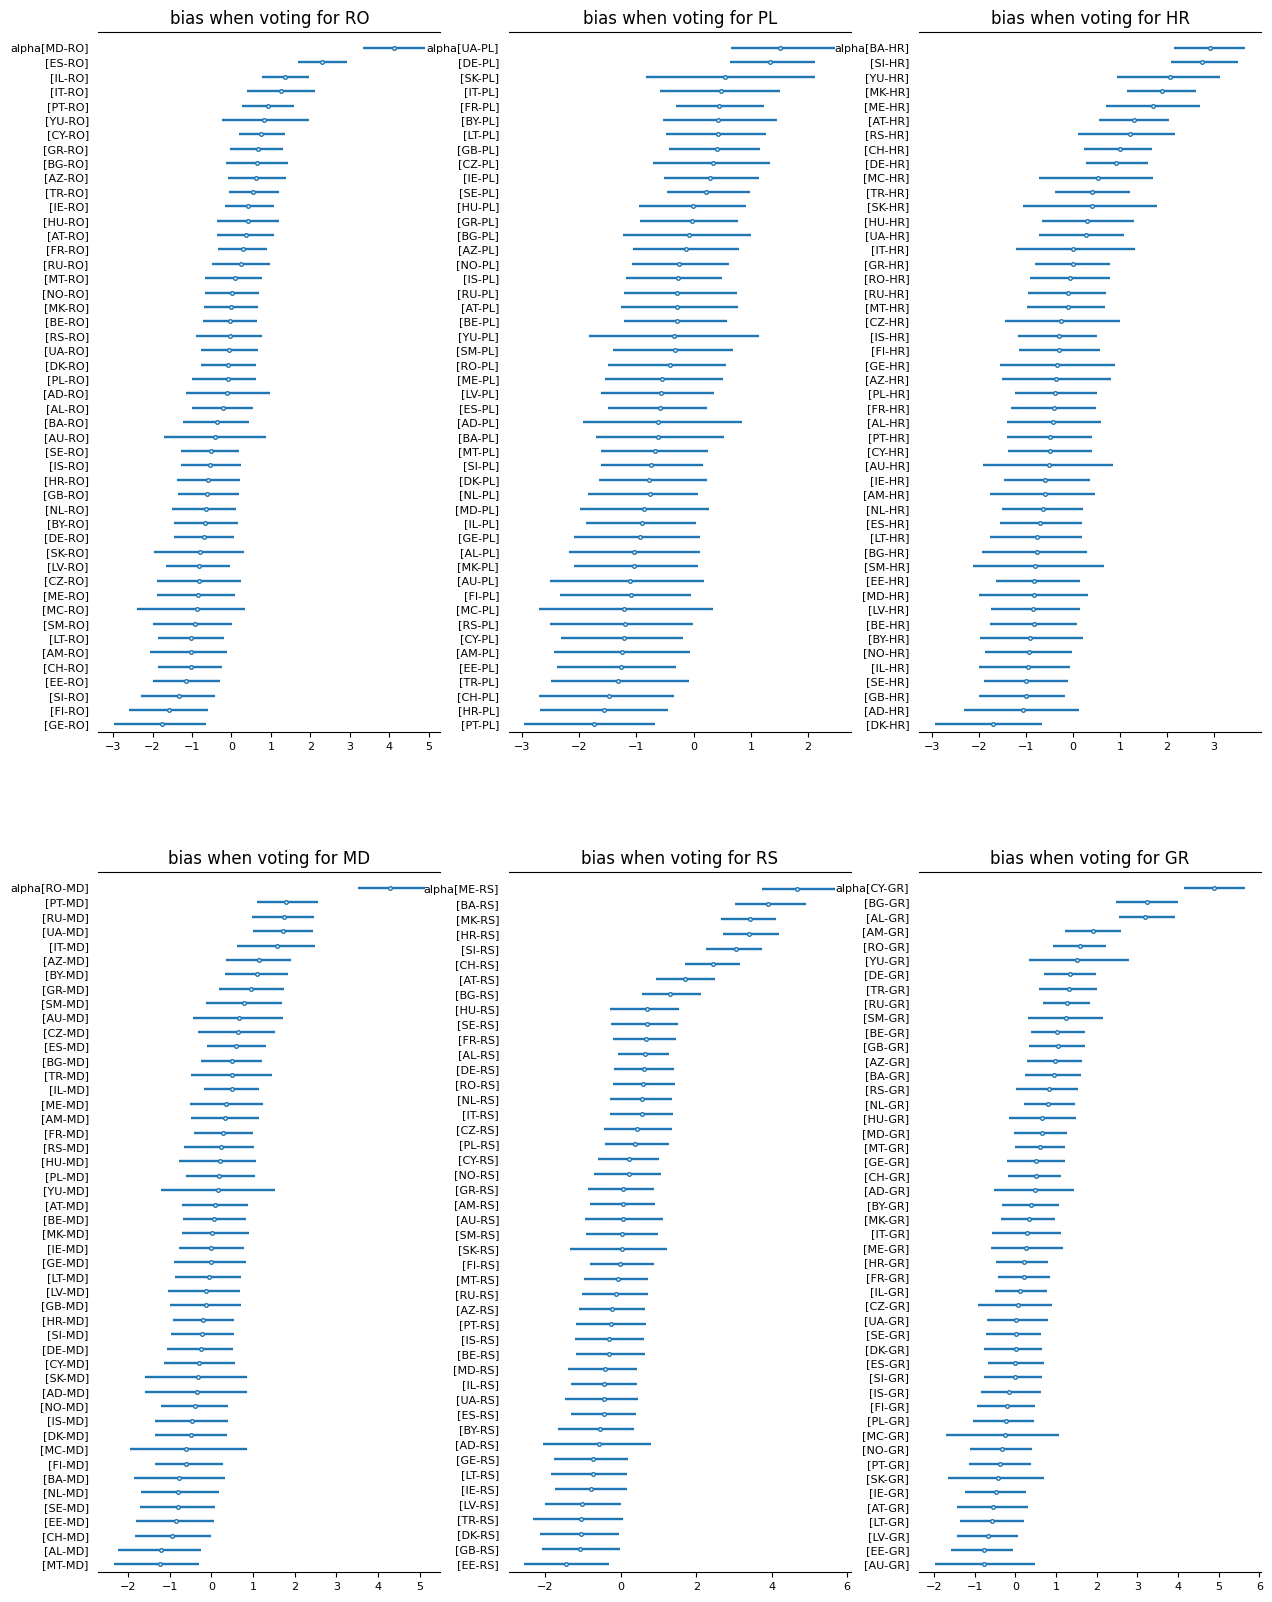

In [111]:
# plotting function for a sorted forest plot for a given performer
def sorted_forest_plot(country_codes):
    nrows = math.ceil(len(country_codes)/3)
    fig,ax = plt.subplots(nrows=nrows,ncols=3)
    fig.set_size_inches(15,10*nrows)
    for idx,c in enumerate(country_codes):
        alpha_means = az_relabelled.posterior.alpha[:,:,votersforp[c]].mean(("chain","draw"))
        sorted_plot_data = az_relabelled.posterior.alpha[:,:,votersforp[c]].sortby(alpha_means,ascending=False)
        axes = az.plot_forest(sorted_plot_data,
                                kind='forestplot',
                                combined=True,
                                quartiles=False,
                                hdi_prob=0.89,
                                textsize=8,
                                ax=ax[math.floor(idx/3),idx % 3],
                                )
        axes[0].set_title(f'bias when voting for {c}')

sorted_forest_plot(big_bias)